In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lambao","key":"d0cc1f51ce80ac5c7bea4f308303057a"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets list -s fruits

ref                                                    title                                               size  lastUpdated          downloadCount  
-----------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
moltean/fruits                                         Fruits 360                                         760MB  2020-05-18 10:35:15          57585  
mjamilmoughal/fruits-with-colors-dataset               Fruits with colors dataset                          816B  2018-01-13 10:22:33           7203  
sriramr/fruits-fresh-and-rotten-for-classification     Fruits fresh and rotten for classification           4GB  2018-08-24 15:05:40           3578  
chrisfilo/fruit-recognition                            Fruit Recognition                                    8GB  2020-02-04 18:52:00           3274  
raghu07/vegetable-and-fruits-price-in-india            Daily Vegetable and Fruits Prices data  2010-

In [4]:
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d moltean/fruits

kaggle.json
 97% 738M/760M [00:03<00:00, 261MB/s]
100% 760M/760M [00:03<00:00, 230MB/s]


In [5]:
!unzip -q fruits.zip -d .

In [99]:
import cv2
import keras
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.models import load_model
from keras.datasets import cifar10
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD

131


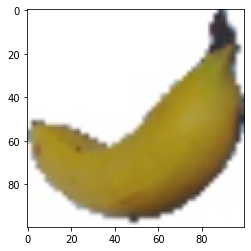

In [7]:
fruit_name = glob.glob('/content/fruits-360/Training/*')
print(len(fruit_name))
check_img = cv2.imread("/content/fruits-360/Training/Banana/0_100.jpg")
check_img = cv2.cvtColor(check_img,cv2.COLOR_RGB2BGR)
# check_img = cv2.resize(check_img,(64,64))
plt.imshow(check_img)

In [127]:
# Training data
training_fruits_img = []
training_label = []
fig, axs = plt.subplots(17,8, figsize=(60, 55), sharey='row')
image1 = cv2.imread("/content/fruits-360/Training/Cauliflower/75_100.jpg")
image1 = cv2.cvtColor(image1,cv2.COLOR_RGB2BGR)
a=0
axs = axs.ravel()
for fruit_name in glob.glob('/content/fruits-360/Training/*'):
  fruits_label = fruit_name.split("/")[4]
  axs[0].imshow(image1)
  axs[0].set_title(str("Cauliflower"),fontsize=40)
  a+=1
  for fuit_detail in glob.glob(os.path.join(fruit_name,"*.jpg")):
    image_fetch = cv2.imread(fuit_detail)
    image_fetch = cv2.cvtColor(image_fetch,cv2.COLOR_RGB2BGR) 
    image_fetch = cv2.resize(image_fetch,(64,64))
    training_fruits_img.append(image_fetch)
    training_label.append(fruits_label)
  axs[a].imshow(image_fetch)
  axs[a].set_title(str(fruits_label).replace("Training", ""),fontsize=40)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [128]:
# Test data
test_fruits_img = []
test_label = []
fig, axs = plt.subplots(17,8, figsize=(60, 55), sharey='row')
image1 = cv2.imread("/content/fruits-360/Test/Cauliflower/r2_202_100.jpg")
image1 = cv2.cvtColor(image1,cv2.COLOR_RGB2BGR)
a=0
axs = axs.ravel()
for fruit_name in glob.glob('/content/fruits-360/Test/*'):
  fruits_label = fruit_name.split("/")[4]
  axs[0].imshow(image1)
  axs[0].set_title(str("Cauliflower"),fontsize=40)
  a+=1
  for fuit_detail in glob.glob(os.path.join(fruit_name,"*.jpg")):
    image_fetch = cv2.imread(fuit_detail)
    image_fetch = cv2.cvtColor(image_fetch,cv2.COLOR_RGB2BGR) 
    image_fetch = cv2.resize(image_fetch,(64,64))
    test_fruits_img.append(image_fetch)
    test_label.append(fruits_label)
  axs[a].imshow(image_fetch)
  axs[a].set_title(str(fruits_label).replace("Test", ""),fontsize=40)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [129]:
# convert to array & normalization
x_train =  np.array(training_fruits_img)
y_train =  np.array(training_label)
x_test = np.array(test_fruits_img)
y_test = np.array(test_label)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [130]:
# release memory
del(training_fruits_img)
del(training_label)
del(test_fruits_img)
del(test_label)

In [131]:
#label encoding for label
label_to_enc = {v:k for k,v in enumerate(np.unique(y_train)) }
y_train_enc = np.array([label_to_enc[i] for i in y_train])
y_test_enc = np.array([label_to_enc[i] for i in y_test])
label_to_enc

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Corn': 35,
 'Corn Husk': 36,
 'Cucumber Ripe': 37,
 'Cucumber Ripe 2': 38,
 'Dates': 39,
 'Eggplant': 40,
 'Fig': 41,
 'Ginger Root': 42,
 'Granadilla': 43,
 'Grape Blue': 44,
 'Grape Pink': 45,
 'Grape White': 46,
 'Grape White 2': 47,
 'Grape White 3': 48,
 'Grap

In [133]:
y_train_ = np_utils.to_categorical(y_train_enc,131)
y_test_ = np_utils.to_categorical(y_test_enc,131)
print(len(y_train_))
print(len(y_test_))

67692
22688


In [134]:
############  builld, compilling model
num_class=len(list(set(y_train)))
batch =32
epochs = 10 
lr = 0.01

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",padding='same',input_shape=x_train.shape[1:]))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation="relu"))
model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_class,activation="softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer = SGD(lr),
              metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)       

In [135]:
############  train model
history = model.fit(x_train,y_train_,
          batch_size=batch,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test,y_test_))
score = model.evaluate(x_test,y_test_,verbose=0) 

Epoch 1/10
2116/2116 [==============================] - 27s 12ms/step - loss: 3.9842 - accuracy: 0.1284 - val_loss: 1.1301 - val_accuracy: 0.7111
Epoch 2/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.7277 - accuracy: 0.7788 - val_loss: 0.5230 - val_accuracy: 0.8529
Epoch 3/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.2182 - accuracy: 0.9284 - val_loss: 0.3268 - val_accuracy: 0.9140
Epoch 4/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.1183 - accuracy: 0.9606 - val_loss: 0.2708 - val_accuracy: 0.9382
Epoch 5/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.0825 - accuracy: 0.9729 - val_loss: 0.2663 - val_accuracy: 0.9423
Epoch 6/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.0571 - accuracy: 0.9815 - val_loss: 0.2687 - val_accuracy: 0.9458
Epoch 7/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.0469 - accuracy: 0.9847 - val_loss: 0.2534 -

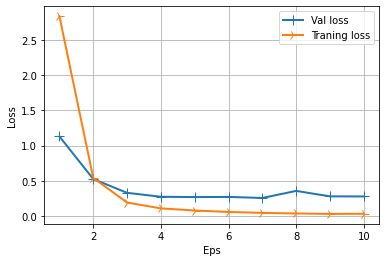

In [136]:
# TRAING/ VALIDATION LOSS
history_dict = history.history
train_loss_val = history_dict['loss']
val_loss_val = history_dict['val_loss']
epoch = range(1, len(val_loss_val)+1)

line1 = plt.plot(epoch, val_loss_val, label='Val loss')
line2 = plt.plot(epoch, train_loss_val, label='Traning loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Eps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [138]:
pred= model.predict(x_test)
y_pred=np.zeros(22688)
for i in range(22688):
    y_pred[i]=np.argmax(pred[i])
print(y_pred)
y_pred.shape

[67. 67.  3. ... 97. 97. 97.]


(22688,)

In [151]:
y_pred[20000]

98.0

In [152]:
y_test_enc[20000]

98

In [142]:
# CLASSIFICATION REPORT
cnn_report = metrics.classification_report(y_test_enc,y_pred)
print(cnn_report)

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       164
           1       1.00      0.89      0.94       148
           2       1.00      1.00      1.00       160
           3       0.87      1.00      0.93       164
           4       0.60      1.00      0.75       161
           5       1.00      0.73      0.85       164
           6       0.90      0.99      0.94       152
           7       1.00      1.00      1.00       164
           8       0.89      0.87      0.88       164
           9       1.00      1.00      1.00       144
          10       0.99      1.00      0.99       166
          11       1.00      0.87      0.93       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       0.98      1.00      0.99       143
          15       0.98      1.00      0.99       166
          16       1.00      0.73      0.84       166
          17       0.91    